In [180]:
# connet google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [181]:
path = '/content/gdrive/MyDrive/PhD/Hand/Data/'

In [190]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import random
from tqdm import tqdm
from os import X_OK
from numpy import array
from sklearn.model_selection import KFold, StratifiedKFold

In [183]:
data = np.load(path + 'combData.npy')
Y = np.load(path + 'label.npy')

In [172]:
# split training and test data set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, random_state=10, stratify=Y)

In [173]:
# only use one time and one variable 
def OneVar1Exp(x, y, one2x, smp_fqc, n_time, n_var):
  '''
  this function is used to convert original 4d data to 2d format to train
  x: input 4d data
  one2x: split one instance to x "instances" to increase training data set
  smp_fqc: the sample fequency for each sequence
  n_time: the number of experiment to be sample
  n_var: which variable should be sample
  '''
  len_data, len_ts = x.shape[0], x.shape[2]
  new_insts, new_ts = len_data*one2x, len_ts//smp_fqc
  X = np.zeros((new_insts, new_ts))
  Y = np.zeros((new_insts,))
  for i in range(new_insts):
    Y[i] = y[i//one2x]
    for t in range(new_ts):
      X[i, t] = x[i//one2x, n_time, t*smp_fqc + (i%one2x)*one2x, n_var]
  return X, Y


def OneVar1Exp4test(x, y, smp_fqc, n_time, n_var):
  len_data, len_ts = x.shape[0], x.shape[2]
  new_ts = len_ts//smp_fqc
  X = np.zeros((len_data, new_ts))
  for i in range(len_data):
    for t in range(new_ts):
      X[i, t] = x[i, n_time, t*smp_fqc, n_var]
  return X, y



def mulVarMulExp():
  pass

In [174]:
X_train, Y_train = OneVar1Exp(x_train, y_train, 10, 100, 0, 0)
X_test, Y_test = OneVar1Exp4test(x_test, y_test, 100, 0, 0)

In [175]:
Y_train.shape

(440,)

In [176]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# define model
model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(1)))
# model.add(Dense(1, activation='sigmoid'))
model.add(LSTM(100, input_shape= (99, 1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='mse')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
"""
n = 0
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
for train_idx, val_idx in skf.split(X_train, Y_train):
  n += 1
  print('training #', n, '......', sep='')
  train_X, train_Y = X_train[train_idx], Y_train[train_idx]
  val_X, val_Y = X_train[val_idx], Y_train[val_idx]
  hist = model.fit(train_X, train_Y, epochs=50, verbose=0, validation_data=(val_X, val_Y))
"""
# train_X, val_X, train_Y, val_Y = train_test_split(X_train, Y_train, test_size=0.2, random_state=10, stratify=Y)
idx = list(range(0, Y_train.shape[0]))
random.shuffle(idx)
X_train, Y_train = X_train[idx], Y_train[idx]
train_X, val_X = X_train[:300].copy(), X_train[300:].copy()
train_Y, val_Y = Y_train[:300].copy(), Y_train[300:].copy()
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))
hist = model.fit(train_X, train_Y, epochs=50, verbose=0, validation_data=(val_X, val_Y))

In [145]:
# tf.keras.utils.plot_model(model, to_file='simLSTM.png')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 50)                10400     
                                                                 
 dense_52 (Dense)            (None, 50)                2550      
                                                                 
 dense_53 (Dense)            (None, 25)                1275      
                                                                 
 dense_54 (Dense)            (None, 10)                260       
                                                                 
 dense_55 (Dense)            (None, 1)                 11        
                                                                 
Total params: 14,496
Trainable params: 14,496
Non-trainable params: 0
_________________________________________________________________


In [49]:
val_X.shape

AttributeError: ignored

In [15]:
print(hist.history.keys())

dict_keys(['loss', 'val_loss'])


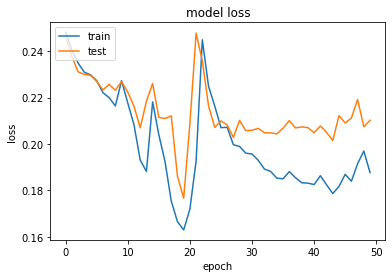

In [177]:
# plot training history
import matplotlib.pyplot as plt
# summarize history for accuracy
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [178]:
# calculate accuracy
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_pred = model(X_test)
print(y_pred)

tf.Tensor(
[[0.02210064]
 [0.50739175]
 [0.4950016 ]
 [0.77091557]
 [0.4869884 ]
 [0.24392852]
 [0.56968987]
 [0.4589052 ]
 [0.491593  ]
 [0.5527912 ]
 [0.5679392 ]
 [0.08211349]
 [0.43768337]
 [0.08619348]
 [0.5372881 ]
 [0.521891  ]
 [0.5634989 ]
 [0.9900309 ]
 [0.2691811 ]], shape=(19, 1), dtype=float32)


In [179]:
y_pred = [1 if y>0.5 else 0 for y in y_pred]
acc = (y_pred == Y_test).sum()/len(Y_test)
print(acc)

0.42105263157894735


In [45]:
x_test.shape

(19, 7, 9988, 48)

In [14]:
X_train[10, 80]

-3.0792

In [15]:
x_train[1, 0, 8000, 0]

-3.0792

In [48]:
X_train.shape

(440, 99)

In [21]:
y_train[10:20]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [196]:
def defLSTM():
    # define model
    model = Sequential()
    model.add(LSTM(500, input_shape= (99, 1)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def myFit(m, X_train, Y_train, s):
    idx = list(range(0, Y_train.shape[0]))
    random.seed(s)
    random.shuffle(idx)
    X_train, Y_train = X_train[idx], Y_train[idx]
    train_X, val_X = X_train[:300].copy(), X_train[300:].copy()
    train_Y, val_Y = Y_train[:300].copy(), Y_train[300:].copy()
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
    val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))
    hist = m.fit(train_X, train_Y, epochs=50, verbose=0, validation_data=(val_X, val_Y))
    return hist, m


def evaluate(model, X_test, Y_test):
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred = model(X_test)
    y_pred = [1 if y>0.5 else 0 for y in y_pred]
    acc = (y_pred == Y_test).sum()/len(Y_test)
    return acc


def train(data, Y):
    # split training and test data set
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, random_state=10, stratify=Y)

    rslt = np.zeros((7, 48))

    for e in range(7):          # the time of experiments
        for v in tqdm(range(48)):     # the number of variable to be use in training
            X_train, Y_train = OneVar1Exp(x_train, y_train, 10, 100, e, v)
            X_test, Y_test = OneVar1Exp4test(x_test, y_test, 100, e, v)
            accs = list()
            for i in range(10): # train 10 times and calculate the average of accuracies
                model = defLSTM()
                hist, model = myFit(model, X_train, Y_train, i)
                acc = evaluate(model, X_test, Y_test)
                accs.append(acc)
            acc_mean = sum(accs)/len(accs)
            rslt[e, v] = acc_mean
            print(e, v, acc_mean)
    np.save('/content/gdrive/MyDrive/PhD/Hand/Data' + 'simplstm_rslt', rslt)


In [ ]:
train(data, Y)

  2%|▏         | 1/48 [01:59<1:33:53, 119.86s/it]

0 0 0.5842105263157895


  4%|▍         | 2/48 [03:57<1:30:53, 118.56s/it]

0 1 0.5842105263157895


  6%|▋         | 3/48 [05:54<1:28:18, 117.74s/it]

0 2 0.5


  8%|▊         | 4/48 [07:53<1:26:47, 118.35s/it]

0 3 0.4894736842105263


 10%|█         | 5/48 [09:51<1:24:39, 118.13s/it]

0 4 0.4947368421052631


 12%|█▎        | 6/48 [11:48<1:22:28, 117.83s/it]

0 5 0.48421052631578937


 15%|█▍        | 7/48 [13:46<1:20:34, 117.93s/it]

0 6 0.4947368421052631


 17%|█▋        | 8/48 [15:45<1:18:53, 118.34s/it]

0 7 0.5105263157894736


 19%|█▉        | 9/48 [17:42<1:16:33, 117.77s/it]

0 8 0.4894736842105263


 21%|██        | 10/48 [19:40<1:14:33, 117.73s/it]

0 9 0.5368421052631579


 23%|██▎       | 11/48 [21:38<1:12:43, 117.95s/it]

0 10 0.536842105263158


 25%|██▌       | 12/48 [23:34<1:10:28, 117.46s/it]

0 11 0.5473684210526315


 27%|██▋       | 13/48 [25:34<1:08:50, 118.02s/it]

0 12 0.5842105263157895


 29%|██▉       | 14/48 [27:31<1:06:44, 117.78s/it]

0 13 0.5684210526315789


 31%|███▏      | 15/48 [29:28<1:04:42, 117.66s/it]

0 14 0.5210526315789473


 33%|███▎      | 16/48 [31:24<1:02:31, 117.23s/it]

0 15 0.41052631578947374


 35%|███▌      | 17/48 [33:21<1:00:27, 117.03s/it]

0 16 0.4526315789473684


 38%|███▊      | 18/48 [35:17<58:23, 116.79s/it]  

0 17 0.4842105263157895


 40%|███▉      | 19/48 [37:13<56:15, 116.39s/it]

0 18 0.4999999999999999


 42%|████▏     | 20/48 [39:09<54:15, 116.26s/it]

0 19 0.4894736842105263


 44%|████▍     | 21/48 [41:05<52:15, 116.14s/it]

0 20 0.4999999999999999


 46%|████▌     | 22/48 [43:03<50:35, 116.74s/it]

0 21 0.5421052631578946


 48%|████▊     | 23/48 [45:00<48:43, 116.94s/it]

0 22 0.5684210526315789


 50%|█████     | 24/48 [47:08<48:03, 120.14s/it]

0 23 0.5526315789473685


 52%|█████▏    | 25/48 [49:04<45:38, 119.07s/it]

0 24 0.5947368421052632


 54%|█████▍    | 26/48 [51:02<43:28, 118.56s/it]

0 25 0.536842105263158


 56%|█████▋    | 27/48 [52:59<41:20, 118.13s/it]

0 26 0.4894736842105263


 58%|█████▊    | 28/48 [54:57<39:20, 118.04s/it]

0 27 0.43157894736842106


 60%|██████    | 29/48 [57:04<38:15, 120.80s/it]

0 28 0.4631578947368421


 62%|██████▎   | 30/48 [59:02<36:02, 120.14s/it]

0 29 0.5052631578947369


 65%|██████▍   | 31/48 [1:01:10<34:39, 122.32s/it]

0 30 0.4999999999999999


 67%|██████▋   | 32/48 [1:03:09<32:19, 121.22s/it]

0 31 0.4578947368421053


 69%|██████▉   | 33/48 [1:05:07<30:05, 120.35s/it]

0 32 0.4999999999999999


 71%|███████   | 34/48 [1:07:03<27:49, 119.24s/it]

0 33 0.5473684210526315


 73%|███████▎  | 35/48 [1:09:01<25:44, 118.84s/it]

0 34 0.5315789473684209


 75%|███████▌  | 36/48 [1:10:59<23:41, 118.44s/it]

0 35 0.5210526315789474


 77%|███████▋  | 37/48 [1:12:57<21:42, 118.42s/it]

0 36 0.6421052631578947


 79%|███████▉  | 38/48 [1:14:55<19:42, 118.25s/it]

0 37 0.45789473684210524


 81%|████████▏ | 39/48 [1:16:53<17:43, 118.19s/it]

0 38 0.47894736842105257


 83%|████████▎ | 40/48 [1:18:51<15:44, 118.10s/it]

0 39 0.4578947368421053


 85%|████████▌ | 41/48 [1:20:46<13:39, 117.05s/it]

0 40 0.5


 88%|████████▊ | 42/48 [1:22:43<11:43, 117.29s/it]

0 41 0.5315789473684209


 90%|████████▉ | 43/48 [1:24:39<09:44, 116.83s/it]

0 42 0.5052631578947369


 92%|█████████▏| 44/48 [1:26:36<07:47, 116.82s/it]

0 43 0.531578947368421


 94%|█████████▍| 45/48 [1:28:31<05:49, 116.39s/it]

0 44 0.4999999999999999


 96%|█████████▌| 46/48 [1:30:29<03:53, 116.76s/it]

0 45 0.5421052631578949


 98%|█████████▊| 47/48 [1:32:29<01:57, 117.60s/it]

0 46 0.5578947368421052


100%|██████████| 48/48 [1:34:26<00:00, 118.05s/it]


0 47 0.5473684210526315


  2%|▏         | 1/48 [01:57<1:32:24, 117.98s/it]

1 0 0.6105263157894736


  4%|▍         | 2/48 [03:56<1:30:34, 118.15s/it]

1 1 0.5736842105263158


  6%|▋         | 3/48 [05:52<1:27:54, 117.22s/it]

1 2 0.4894736842105263


  8%|▊         | 4/48 [07:49<1:26:01, 117.30s/it]

1 3 0.43684210526315786


 10%|█         | 5/48 [09:46<1:23:53, 117.06s/it]

1 4 0.5157894736842106


 12%|█▎        | 6/48 [11:44<1:22:15, 117.50s/it]

1 5 0.5263157894736843


 15%|█▍        | 7/48 [13:40<1:19:50, 116.84s/it]

1 6 0.5


 17%|█▋        | 8/48 [15:35<1:17:37, 116.44s/it]

1 7 0.5052631578947369


 19%|█▉        | 9/48 [17:33<1:15:50, 116.67s/it]

1 8 0.4999999999999999


 21%|██        | 10/48 [19:29<1:13:47, 116.52s/it]

1 9 0.5578947368421053


 23%|██▎       | 11/48 [21:24<1:11:39, 116.19s/it]

1 10 0.5421052631578948


 25%|██▌       | 12/48 [23:20<1:09:38, 116.07s/it]

1 11 0.5473684210526317


 27%|██▋       | 13/48 [25:17<1:07:53, 116.38s/it]

1 12 0.5894736842105263


 29%|██▉       | 14/48 [27:23<1:07:36, 119.30s/it]

1 13 0.5947368421052631


 31%|███▏      | 15/48 [29:18<1:04:52, 117.96s/it]

1 14 0.5105263157894737


 33%|███▎      | 16/48 [31:16<1:02:51, 117.86s/it]

1 15 0.35789473684210527


 35%|███▌      | 17/48 [33:14<1:00:54, 117.89s/it]

1 16 0.46842105263157896


 38%|███▊      | 18/48 [35:10<58:42, 117.43s/it]  

1 17 0.4894736842105264


 40%|███▉      | 19/48 [37:10<57:05, 118.13s/it]

1 18 0.4947368421052631


 42%|████▏     | 20/48 [39:07<54:59, 117.85s/it]

1 19 0.47368421052631576


 44%|████▍     | 21/48 [41:04<52:58, 117.73s/it]

1 20 0.4947368421052631


 46%|████▌     | 22/48 [43:03<51:12, 118.17s/it]

1 21 0.5578947368421051


 48%|████▊     | 23/48 [45:00<49:01, 117.65s/it]

1 22 0.5631578947368421


 50%|█████     | 24/48 [46:57<47:00, 117.52s/it]

1 23 0.5473684210526315


 52%|█████▏    | 25/48 [48:54<44:59, 117.36s/it]

1 24 0.6789473684210525


 54%|█████▍    | 26/48 [50:50<42:49, 116.80s/it]

1 25 0.47894736842105257


 56%|█████▋    | 27/48 [52:49<41:07, 117.48s/it]

1 26 0.46315789473684205


 58%|█████▊    | 28/48 [54:47<39:15, 117.76s/it]

1 27 0.43157894736842106


 60%|██████    | 29/48 [56:46<37:24, 118.14s/it]

1 28 0.4789473684210527


 62%|██████▎   | 30/48 [58:45<35:28, 118.24s/it]

1 29 0.4842105263157895


 65%|██████▍   | 31/48 [1:00:43<33:29, 118.18s/it]

1 30 0.4947368421052631


 67%|██████▋   | 32/48 [1:02:41<31:33, 118.33s/it]

1 31 0.4947368421052632


 69%|██████▉   | 33/48 [1:04:43<29:48, 119.23s/it]

1 32 0.5052631578947369


 71%|███████   | 34/48 [1:06:41<27:47, 119.07s/it]

1 33 0.5473684210526317


 73%|███████▎  | 35/48 [1:08:42<25:54, 119.59s/it]

1 34 0.5473684210526315


 75%|███████▌  | 36/48 [1:10:50<24:26, 122.17s/it]

1 35 0.5368421052631579


 77%|███████▋  | 37/48 [1:12:48<22:09, 120.88s/it]

1 36 0.6842105263157895


 79%|███████▉  | 38/48 [1:14:48<20:05, 120.51s/it]

1 37 0.48421052631578954


 81%|████████▏ | 39/48 [1:16:47<17:59, 119.99s/it]

1 38 0.4526315789473684


 83%|████████▎ | 40/48 [1:18:46<15:58, 119.84s/it]

1 39 0.4789473684210527


 85%|████████▌ | 41/48 [1:20:45<13:56, 119.53s/it]

1 40 0.48421052631578937


 88%|████████▊ | 42/48 [1:22:44<11:55, 119.31s/it]

1 41 0.5


 90%|████████▉ | 43/48 [1:24:42<09:55, 119.13s/it]

1 42 0.5052631578947369


 92%|█████████▏| 44/48 [1:26:41<07:55, 118.85s/it]

1 43 0.4473684210526316


 94%|█████████▍| 45/48 [1:28:39<05:55, 118.62s/it]

1 44 0.4947368421052631


 96%|█████████▌| 46/48 [1:30:38<03:57, 118.68s/it]

1 45 0.5368421052631579


 98%|█████████▊| 47/48 [1:32:36<01:58, 118.69s/it]

1 46 0.5736842105263158


100%|██████████| 48/48 [1:34:35<00:00, 118.23s/it]


1 47 0.5631578947368421


  2%|▏         | 1/48 [01:58<1:32:59, 118.71s/it]

2 0 0.5263157894736842


  4%|▍         | 2/48 [03:56<1:30:36, 118.18s/it]

2 1 0.5263157894736842


  6%|▋         | 3/48 [05:54<1:28:27, 117.94s/it]

2 2 0.5631578947368421


  8%|▊         | 4/48 [08:03<1:29:49, 122.49s/it]

2 3 0.4947368421052631


 10%|█         | 5/48 [09:59<1:26:09, 120.23s/it]

2 4 0.5210526315789473


 12%|█▎        | 6/48 [11:59<1:23:58, 119.97s/it]

2 5 0.46842105263157896


 15%|█▍        | 7/48 [13:57<1:21:35, 119.41s/it]

2 6 0.4999999999999999


 17%|█▋        | 8/48 [15:55<1:19:15, 118.89s/it]

2 7 0.4894736842105263


 19%|█▉        | 9/48 [17:53<1:17:04, 118.57s/it]

2 8 0.5052631578947369


 21%|██        | 10/48 [19:51<1:14:56, 118.34s/it]

2 9 0.5421052631578948


 23%|██▎       | 11/48 [21:48<1:12:44, 117.96s/it]

2 10 0.5421052631578946


 25%|██▌       | 12/48 [23:45<1:10:40, 117.80s/it]

2 11 0.5157894736842106


 27%|██▋       | 13/48 [25:42<1:08:36, 117.61s/it]

2 12 0.5736842105263158


 29%|██▉       | 14/48 [27:39<1:06:31, 117.41s/it]

2 13 0.5578947368421052


 31%|███▏      | 15/48 [29:35<1:04:19, 116.95s/it]

2 14 0.4789473684210527


 33%|███▎      | 16/48 [31:33<1:02:32, 117.28s/it]

2 15 0.36842105263157887


 35%|███▌      | 17/48 [33:31<1:00:44, 117.56s/it]

2 16 0.44210526315789467


 38%|███▊      | 18/48 [35:30<58:57, 117.93s/it]  

2 17 0.4842105263157895


 40%|███▉      | 19/48 [37:29<57:04, 118.10s/it]

2 18 0.5105263157894736


 42%|████▏     | 20/48 [39:27<55:07, 118.12s/it]

2 19 0.4947368421052632


 44%|████▍     | 21/48 [41:26<53:16, 118.40s/it]

2 20 0.4894736842105263


 46%|████▌     | 22/48 [43:23<51:05, 117.90s/it]

2 21 0.5421052631578946


 48%|████▊     | 23/48 [45:19<48:59, 117.57s/it]

2 22 0.5578947368421052


 50%|█████     | 24/48 [47:18<47:08, 117.84s/it]

2 23 0.5526315789473685


 52%|█████▏    | 25/48 [49:15<45:06, 117.68s/it]

2 24 0.631578947368421


 54%|█████▍    | 26/48 [51:14<43:19, 118.16s/it]

2 25 0.5105263157894737


 56%|█████▋    | 27/48 [53:15<41:37, 118.92s/it]

2 26 0.47894736842105257


 58%|█████▊    | 28/48 [55:13<39:29, 118.47s/it]

2 27 0.41052631578947374


 60%|██████    | 29/48 [57:09<37:19, 117.88s/it]

2 28 0.46315789473684205


 62%|██████▎   | 30/48 [59:08<35:29, 118.30s/it]

2 29 0.5210526315789473


 65%|██████▍   | 31/48 [1:01:06<33:27, 118.10s/it]

2 30 0.46842105263157896
